In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras import layers
import keras_tuner



In [3]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+type+'/parameters_v1.txt')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)

    return df

df = read_data(type='CRUSHING', folder='CONSTANT_THICKNESS_100', length=100)
df.head()

,mean_force,max_force,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs
0,116.183099,187.578344,2.50,2.15,1.63,75.95,127.83,263.44,66771.2
1,125.198705,202.560469,2.83,2.02,1.44,75.76,127.25,246.66,69501.7
2,117.235652,205.683984,2.85,1.78,1.44,76.51,127.53,243.62,65759.5
3,113.854128,190.665063,2.71,1.72,1.51,75.41,127.61,258.13,65259.4
4,115.093363,191.023219,2.67,1.74,1.65,76.22,128.53,261.38,65053.8


In [3]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
#Y = df[['max_force', 'mean_force']]
Y = df[['mean_force']].values

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [5]:
SVR_model =SVR(kernel='rbf',C=100,gamma= 0.1)
SVR_model.fit(X_train,Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma=0.1)

In [6]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.8389559


In [7]:
d0_values = np.linspace(10, 1000, 100)
print(d0_values)
results = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    results[d0_values[i]] = mse

[  10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.  120.
  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.
  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.  360.
  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.  480.
  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.
  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.
  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.  840.
  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.  960.
  970.  980.  990. 1000.]
___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing li

{10.0: 4.39248069805209, 20.0: 3.3921470826807627, 30.0: 1.9294835589323807, 40.0: 1.4976471165118954, 50.0: 1.5710492781656376, 60.0: 1.639333703498533, 70.0: 1.6677191669236577, 80.0: 1.677065434651081, 90.0: 1.6779369578807621, 100.0: 1.6742666046811838, 110.0: 1.6674374062369222, 120.0: 1.6579409539635548, 130.0: 1.6459568768894388, 140.0: 1.6316521780329816, 150.0: 1.6151998137698775, 160.0: 1.5968185093858362, 170.0: 1.576888169059236, 180.0: 1.5557452849264966, 190.0: 1.5339108565307038, 200.0: 1.5118492050788137, 210.0: 1.4900393058395094, 220.0: 1.4689701583212744, 230.0: 1.4490939935713567, 240.0: 1.4308095291843683, 250.0: 1.4144801545113355, 260.0: 1.400376798477059, 270.0: 1.3887636640077967, 280.0: 1.3797332786927647, 290.0: 1.3734655628745505, 300.0: 1.369908127799171, 310.0: 1.369062646469333, 320.0: 1.3708069775151819, 330.0: 1.3750196573877382, 340.0: 1.381524455186547, 350.0: 1.390118708362223, 360.0: 1.400596116363577, 370.0: 1.412719988538123, 380.0: 1.426266204923

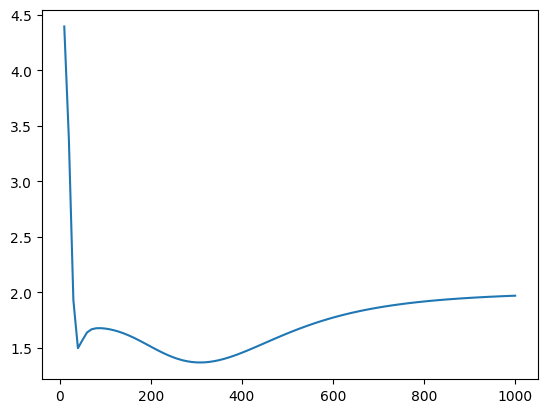

In [8]:
print(results)
plt.plot(results.keys(), results.values())
print(min(results, key=results.get))

In [9]:
RBF_model = RBF(d0=min(results, key=results.get), print_global=False)
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()
Y_pred = RBF_model.predict_values(X_val)

In [10]:
"""def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dropout(rate=0.2))
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=480, step=64), 
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid']),
            ))
        #model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(
        units=1, 
        activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

hp = keras_tuner.HyperParameters()
build_model(hp)

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='mse',
    max_trials=1000,
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='test_1'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)"""


"def build_model(hp):\n    model = keras.Sequential()\n    model.add(keras.Input(shape=(X_train.shape[1],)))\n    model.add(layers.Dropout(rate=0.2))\n    for i in range(hp.Int('num_layers', 1, 10)):\n        model.add(layers.Dense(\n            units=hp.Int(f'units_{i}', min_value=32, max_value=480, step=64), \n            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid']),\n            ))\n        #model.add(layers.Dropout(rate=0.5))\n    model.add(layers.Dense(\n        units=1, \n        activation='sigmoid'))\n    model.compile(\n        optimizer=keras.optimizers.legacy.Adam(\n            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),\n        loss='mse',\n        metrics=['mse'])\n    return model\n\nhp = keras_tuner.HyperParameters()\nbuild_model(hp)\n\ntuner = keras_tuner.RandomSearch(\n    hypermodel=build_model,\n    objective='mse',\n    max_trials=1000,\n    executions_per_trial=1,\n    directory='keras_tuner',\n    project_name='test_1'\n

In [11]:
"""tuner.search_space_summary()"""

'tuner.search_space_summary()'

In [12]:
"""tuner.search(
    X_train, 
    Y_train, 
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val), 
    callbacks=[early_stopping]
    )"""

'tuner.search(\n    X_train, \n    Y_train, \n    epochs=500,\n    batch_size=32,\n    validation_data=(X_val, Y_val), \n    callbacks=[early_stopping]\n    )'

In [13]:
"""models = tuner.get_best_models(num_models=5)
best_model = models[0]
best_model.summary()"""

'models = tuner.get_best_models(num_models=5)\nbest_model = models[0]\nbest_model.summary()'

In [14]:
"""tuner.results_summary()"""

'tuner.results_summary()'

In [15]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mse']
)

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/500


3/3 [==============================] - 0s 45ms/step - loss: 15334.8564 - mse: 15334.8564 - val_loss: 14820.3535 - val_mse: 14820.3535
Epoch 2/500
3/3 [==============================] - 0s 8ms/step - loss: 15253.3184 - mse: 15253.3184 - val_loss: 14722.6504 - val_mse: 14722.6504
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 15134.0215 - mse: 15134.0215 - val_loss: 14553.0439 - val_mse: 14553.0439
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 14923.7051 - mse: 14923.7051 - val_loss: 14249.6533 - val_mse: 14249.6533
Epoch 5/500
3/3 [==============================] - 0s 8ms/step - loss: 14554.8066 - mse: 14554.8066 - val_loss: 13720.7158 - val_mse: 13720.7158
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 13905.6309 - mse: 13905.6309 - val_loss: 12817.7402 - val_mse: 12817.7402
Epoch 7/500
3/3 [==============================] - 0s 7ms/step - loss: 12836.9590 - mse: 12836.9590 - val_loss: 11326.7607 - val_mse: 11326.7

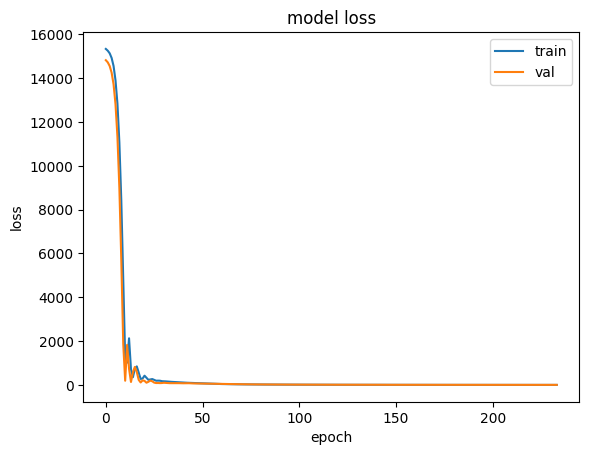

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [17]:
Y_predicted_KRG = KRG_model.predict_values(X_val)
Y_predicted_RBF = RBF_model.predict_values(X_val)
Y_predicted_SVR = SVR_model.predict(X_val)
Y_predicted_ANN = model.predict(X_val)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0058570
   
   Prediction time/pt. (sec) :  0.0002928
   
1/1 [==============================] - 0s 56ms/step


In [18]:
print("MSE, for KRG:", mean_squared_error(Y_val, Y_predicted_KRG))
print("MSE, for RBF:", mean_squared_error(Y_val, Y_predicted_RBF))
print("MSE, for SVR:", mean_squared_error(Y_val, Y_predicted_SVR))
print("MSE, for ANN:", mean_squared_error(Y_val, Y_predicted_ANN))

MSE, for KRG: 4.168400744235404
MSE, for RBF: 1.369062646469333
MSE, for SVR: 1.7683897243958042
MSE, for ANN: 4.837888106417058


In [19]:
mae_KRG = mean_absolute_error(Y_val, Y_predicted_KRG)
mae_RBF = mean_absolute_error(Y_val, Y_predicted_RBF)
mae_SVR = mean_absolute_error(Y_val, Y_predicted_SVR)
mae_ANN = mean_absolute_error(Y_val, Y_predicted_ANN)
print("MAE, for KRG:", mae_KRG)
print("MAE, for RBF:", mae_RBF)
print("MAE, for SVR:", mae_SVR)
print("MAE, for ANN:", mae_ANN)

MAE, for KRG: 1.511612905573236
MAE, for RBF: 0.9148469015596475
MAE, for SVR: 0.9775912181850088
MAE, for ANN: 1.727866178281498


In [20]:
mape_KRG = mean_absolute_percentage_error(Y_val, Y_predicted_KRG)
mape_RBF = mean_absolute_percentage_error(Y_val, Y_predicted_RBF)
mape_SVR = mean_absolute_percentage_error(Y_val, Y_predicted_SVR)
mape_ANN = mean_absolute_percentage_error(Y_val, Y_predicted_ANN)
print("MAPE, for KRG:", format(round(mape_KRG, 4)*100,'.2f'), "%")
print("MAPE, for RBF:", format(round(mape_RBF, 4)*100,'.2f'), "%")
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")
print("MAPE, for ANN:", format(round(mape_ANN, 4)*100,'.2f'), "%")

MAPE, for KRG: 1.24 %
MAPE, for RBF: 0.75 %
MAPE, for SVR: 0.80 %
MAPE, for ANN: 1.42 %


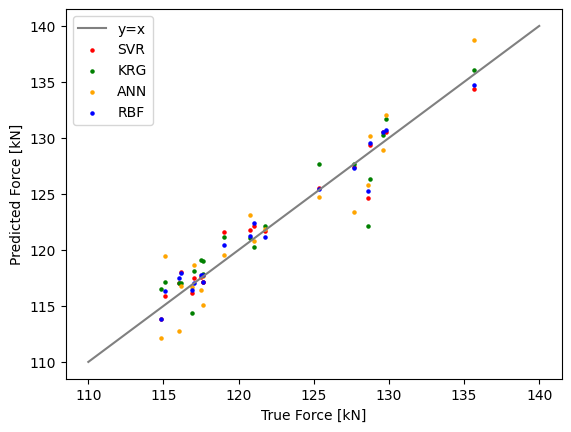

In [21]:
plt.plot([110, 140], [110, 140], label='y=x', color='gray')

plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.scatter(Y_val, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')
plt.scatter(Y_val, Y_predicted_RBF, s=5, label='RBF', color='blue')

plt.xlabel('True Force [kN]')
plt.ylabel('Predicted Force [kN]')
plt.legend()